In [1]:
use_cuda_numpy = False
if use_cuda_numpy:
    import numpy as np
    import matplotlib.pyplot as plt
    import cupy as cnp
    import cupyx.scipy as csp
    import cupyx.scipy.sparse.linalg as clg
    import cupyx.scipy.sparse as csparse
    from time import time
    import os
    
else:
    import numpy as cnp
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy as csp
    import scipy.sparse.linalg as clg
    import scipy.sparse as csparse
    from time import time
    import os

# 1D Time Dependent Schrödinger Equation

### Routines

In [2]:
#Discretized Hamiltonian as a Sparse Matrix
def cuda_get_discrete_U_L(Nx, dx, dt, mx, hbar):
    # it is faster to prepare the diagonals with cpu and then transfer them to gpu
    # since the implementation is very sequential as it is
    # all arguments expected to be in cpu
    # but returned sparse matrix is in gpu
    main_diagonal = 1+1j*dt*0.5*hbar*(1/dx**2/mx)*cnp.ones(Nx, dtype=complex_dtype)
    for i in range(Nx):
        main_diagonal[i] += 1j*dt*V_i[i]/2/hbar
    x_diagonals = -1j*dt*hbar/(4*mx*dx**2)*cnp.ones(Nx-1, dtype=complex_dtype)   
    return csp.sparse.diags( diagonals=
        (main_diagonal, x_diagonals, x_diagonals,),
        offsets=np.array([0, 1, -1]), dtype=complex_dtype,format='csc')

### Simulation Parameters

In [3]:
# name for output directories
exp_name = "torus"

# Complex number precision
complex_dtype = cnp.csingle # 64 bit #cnp.cdouble # 128 bit
real_dtype = cnp.single # 32 bit # cnp.double # 64 bit

# hbar, masses
hbar = 1
ms = [1]

# Time increment
dt = 0.005

# Number of time iterations
numIts = 1400

# Number of points to be used per dimension
Ns = [350] # (Nx, Ny, Nz)
Nx = Ns
 
# Output every
outputEvery = 20

# Number of Bohmian Trajectories to Sample and Evolve
numTrajs = 2000

# Dimensionality of the particles in the 2D configuration space
numDofPartic = 1 # aka a single 1D particle
numDofUniv = 1

# Time grid
ts = np.array([dt*j for j in range(numIts)])

# Intervals for calculating the wave function
xlowers = [-10]
xuppers = [10]

# Increments to be used per dimension
dxs = [(xuppers[j]-xlowers[j])/(Ns[j]-1) for j in range(1)] # (dx, dy)
dx = dxs[0]

#Create coordinates at which the solution will be calculated
nodes = [cnp.linspace(xlowers[j], xuppers[j], Ns[j]) for j in range(1)] # (xs, ys)
xs = nodes[0]

print("> Grid Settings:")
print(f"  Using Nx={Ns[0]} grid points.")
print(f"  Using dx={dxs[0]:.4} increments\n")

> Grid Settings:
  Using Nx=350 grid points.
  Using dx=0.05731 increments



Save the Simulation Parameters

In [4]:
# Save the Simulation Parameters
os.makedirs(f"./OUTPUTS/TISE_{numDofUniv}D/{exp_name}/", exist_ok=True)
with open(f"./OUTPUTS/TISE_{numDofUniv}D/{exp_name}/Settings.txt", "w") as f:
    f.write(f"numIts {numIts}\ndt {dt}\noutputEvery {outputEvery}\nNs {Ns}\nxlowers {xlowers}\nxuppers {xuppers}\n")
    f.write(f"numDofUniv {numDofUniv}\nnumDofPartic {numDofPartic}\n")
    f.write(f"numTrajs {numTrajs}\nhbar {hbar}\nms {ms}\nreal_dtype {real_dtype}\ncomplex_dtype {complex_dtype}\n")
    try:
        f.write(f"K_coulomb {K_coulomb} \nqs {qs}\n")
    except:
        f.write(f"K_coulomb {1} \nqs {[1,1,1]}\n")  

### Scenario

In [5]:
def harmonic(grid):
    return 0.5*cnp.sum(grid**2, -1)

In [6]:
K_coulomb=1
qs = [-1,-1]
# Initial Wavefunction
def psi0_gaussian(grid, mus, sigmas, ps, hbar):
    # grid is [Nx,Ny, 2]
    return np.prod(1/(sigmas*np.sqrt(2*np.pi))**0.5*cnp.exp(-(grid-mus)**2/(4*sigmas**2))*cnp.exp(1j*(ps*grid)/hbar), axis=-1, dtype=complex_dtype)

def psi0_Ngaussians(grid, muss, sigmass, pss, hbar, complex_dtype):
    psi = cnp.zeros(grid.shape[:-1], dtype=complex_dtype)
    for mus, sigmas, ps in zip(muss, sigmass, pss):
        psi+=np.prod(1/(sigmas*np.sqrt(2*np.pi))**0.5*cnp.exp(-(grid-mus)**2/(4*sigmas**2))*cnp.exp(1j*(ps*grid)/hbar), axis=-1, dtype=complex_dtype)
    return psi/np.sqrt(len(muss))

# parameters for gaussian
mus = cnp.array([4])
sigmas = cnp.array([1/np.sqrt(2)])
ps = cnp.array([0.5])

# parameters for 2 gaussians
muss = cnp.array([[4, -0.5]]) 
sigmass = cnp.array([[1.5,1.5]])
#pss = cnp.array([[0,1.5],[0,1.5]])
pss = cnp.array([[0,3]])


# choose the potential and the wavefunction
chosenV=harmonic

# the grid for the potential plot and to allow a speed up using cuda
grid=cnp.array(cnp.meshgrid(*nodes)).T #[Nx, 1]
V_i = chosenV(grid)

#psi0 = lambda grid: harmonic_angular_mom_eig(grid, mus=mus, sigmas=sigmas, ps=ps, hbar=hbar)
psi0 = lambda grid: psi0_Ngaussians(grid, muss=muss, sigmass = sigmass, pss = pss, hbar=hbar,complex_dtype=complex_dtype)

### Simulation
Prepare Arrays

In [7]:
psi = psi0(grid).flatten('F')

In [8]:
U_L = cuda_get_discrete_U_L(*Ns, *dxs, dt, *ms, hbar)
U_R = U_L.conj()
UL_LUdec = clg.splu( U_L )

In [9]:
# initialize Bohmian trajectories
# first get the pdf
#psi0 = cnp.asnumpy(psi)
pdf0 = (psi.conj()*psi).real
pdf0 = pdf0/pdf0.sum() # normalize strictly

# sample randomly
i_s = cnp.random.choice( pdf0.shape[0], 
            replace=True, size=(numTrajs), p=pdf0 ) #[numTrajs] indices

# avoiding edges - probability density is zero there
i_s[i_s==0] = 1
i_s[i_s==Ns[0]-1] = Ns[0]-2

trajs = cnp.zeros((numTrajs, 2*numDofUniv)) #[numTrajs, 2 1posit1momt]
for tr, i in enumerate(i_s):
    trajs[tr, 0] = nodes[0][i]
    
cdxs = cnp.array(dxs)[cnp.newaxis,:]
cNs = cnp.array(Ns)[cnp.newaxis, :]
cxlowers = cnp.array(xlowers)[cnp.newaxis, :]
cxuppers = cnp.array(xuppers)[cnp.newaxis, :]
cms = cnp.array(ms)[cnp.newaxis, :]

Visualize chosen potential energy profile and trajectories

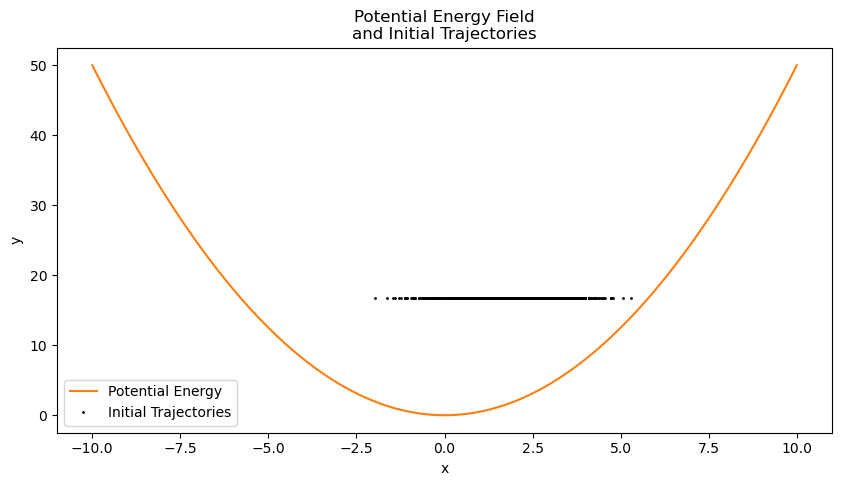

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
if use_cuda_numpy:
    V_i=cnp.asnumpy(V_i)
    trajs_numpy = cnp.asnumpy(trajs)
else:
    trajs_numpy = trajs

ax.plot(xs, V_i, label="Potential Energy", color=u'#ff7f0e')
ax.plot(trajs_numpy[:,0], [np.mean(V_i)]*len(trajs_numpy),'o',
        c="black", markersize=1, label="Initial Trajectories")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Potential Energy Field\nand Initial Trajectories")
#ax.scatter(trajs[:,0], trajs[:,1], c="black", s=2,alpha=1)
os.makedirs(f"./OUTPUTS/TISE_1D/{exp_name}/figs/", exist_ok=True)
image=f"./OUTPUTS/TISE_1D/{exp_name}/figs/energy_potential.png"
plt.legend()
plt.savefig(image, dpi=120, bbox_inches='tight')
plt.show()

Create Directories

In [11]:
os.makedirs(f"./OUTPUTS/TISE_1D/{exp_name}/pdf/", exist_ok=True)
os.makedirs(f"./OUTPUTS/TISE_1D/{exp_name}/trajs/", exist_ok=True)
os.makedirs(f"./OUTPUTS/TISE_1D/{exp_name}/moms/", exist_ok=True)

Run Iterations

In [12]:
dpsi_dx = cnp.zeros(Ns, dtype=complex_dtype)
p = cnp.zeros(dpsi_dx.shape+(1, ), dtype=real_dtype) #[ Nx, 1]

for it, t in enumerate(ts):    
    # BOHMIAN MOMENTUM FIELD #####################################
    # first the gradient of the wavefunction at each point
    # X
    # boundaries with simple Euler formula O(dx)
    dpsi_dx[0] = (psi[1]-psi[0])/dx
    dpsi_dx[-1] = (psi[-1]-psi[-2])/dx
    # next boundaries with centered difference O(dx**2)
    dpsi_dx[1] = (psi[2]-psi[0])/(2*dx)
    dpsi_dx[-2] = (psi[-1]-psi[-3])/(2*dx)
    # rest with O(dx**4) centered difference
    dpsi_dx[2:-2] = (-psi[4:]+8*psi[3:-1]-8*psi[1:-3]+psi[:-4])/(12*dx)

    # px, py, pz
    p[:,0] = hbar*(dpsi_dx/psi).imag
    
    # MOMENTUM ON TRAJS ##################################################
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs[:,:numDofUniv]-cxlowers)//cdxs).T).astype(cnp.uint) # [1, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,cnp.newaxis]
    # Interpolate momentum
    trajs[:,numDofUniv:] = ratx_down* p[ trajs_idxs[0]+1 ] +\
        (1-ratx_down)* p[ trajs_idxs[0], ] 
    
    # Before moving the trajectories, we save the state (with the positions and velocities of this time)
    # OUTPUT #####################################################
    if it%outputEvery == 0:
        print(f"\n > It {it}/{numIts}")
        # compute the magnitude squared of the wavefunction
        pdf = (psi.conj()*psi).real
        # Approximate the norm
        print(f"   Iteration {it} Approx.Norm = {pdf.sum()*dx:.4}")
        if use_cuda_numpy:
            pdf = cnp.asnumpy(pdf)
            trajs_numpy = cnp.asnumpy(trajs)
            p_numpy = cnp.asnumpy(p)
        else:
            trajs_numpy = trajs
            p_numpy = p
        np.save(f"./OUTPUTS/TISE_1D/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                pdf, allow_pickle=True) #[Nx]
        np.save(f"./OUTPUTS/TISE_1D/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                trajs_numpy, allow_pickle=True) #[numTrajs, 2]
        np.save(f"./OUTPUTS/TISE_1D/{exp_name}/moms/momentum_field_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                p_numpy, allow_pickle=True) #[Nx, 1]    
    # NEXT TIME ITERATION POSITIONS ##############################################
    # Evolve trajectories using the interpolated momentum field
    trajs[:,:numDofUniv] = trajs[:,:numDofUniv] + dt*trajs[:,numDofUniv:]/cms #[numTrajs, 4]
    
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    patience = 2 # max three bounces allowed
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    while(cnp.any(trajs[:,:numDofUniv]>=cxuppers) or cnp.any(trajs[:,:numDofUniv]<cxlowers)):
        trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]>=cxuppers, cxuppers-(trajs[:,:numDofUniv]-cxuppers)-1e-10 ,trajs[:,:numDofUniv] )
        trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]<cxlowers, cxlowers+(cxlowers-trajs[:,:numDofUniv]) ,trajs[:,:numDofUniv] )
        patience-=1
        if patience==0:
            trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]>=cxuppers, cxuppers-1e-10,trajs[:,:numDofUniv] )
            trajs[:,:numDofUniv] = cnp.where( trajs[:,:numDofUniv]< cxlowers, cxlowers,trajs[:,:numDofUniv] )
            break      
    # NEXT PSI ####################################################
    # compute the next time iteration's wavefunction
    U_Rpsi_prev = U_R@psi # this is the vector b in Ax=b
    psi = UL_LUdec.solve(U_Rpsi_prev)



 > It 0/1400
   Iteration 0 Approx.Norm = 0.01982

 > It 20/1400
   Iteration 20 Approx.Norm = 0.01982

 > It 40/1400
   Iteration 40 Approx.Norm = 0.01982

 > It 60/1400
   Iteration 60 Approx.Norm = 0.01982

 > It 80/1400
   Iteration 80 Approx.Norm = 0.01982

 > It 100/1400
   Iteration 100 Approx.Norm = 0.01982

 > It 120/1400
   Iteration 120 Approx.Norm = 0.01982

 > It 140/1400
   Iteration 140 Approx.Norm = 0.01982

 > It 160/1400
   Iteration 160 Approx.Norm = 0.01982

 > It 180/1400
   Iteration 180 Approx.Norm = 0.01982

 > It 200/1400
   Iteration 200 Approx.Norm = 0.01982

 > It 220/1400
   Iteration 220 Approx.Norm = 0.01982

 > It 240/1400
   Iteration 240 Approx.Norm = 0.01982

 > It 260/1400
   Iteration 260 Approx.Norm = 0.01982

 > It 280/1400
   Iteration 280 Approx.Norm = 0.01982

 > It 300/1400
   Iteration 300 Approx.Norm = 0.01982

 > It 320/1400
   Iteration 320 Approx.Norm = 0.01982

 > It 340/1400
   Iteration 340 Approx.Norm = 0.01982

 > It 360/1400
   Ite

Free stuff

In [13]:
if use_cuda_numpy:
    cnp.get_default_memory_pool().free_all_blocks()
    cnp.get_default_pinned_memory_pool().free_all_blocks()

### Animation Generation

Generate png

In [14]:
if use_cuda_numpy:
    nodes = [cnp.asnumpy(nodel) for nodel in nodes]


 > It 0/1400

 > It 20/1400

 > It 40/1400

 > It 60/1400

 > It 80/1400

 > It 100/1400

 > It 120/1400

 > It 140/1400

 > It 160/1400

 > It 180/1400

 > It 200/1400

 > It 220/1400

 > It 240/1400

 > It 260/1400

 > It 280/1400

 > It 300/1400

 > It 320/1400

 > It 340/1400

 > It 360/1400

 > It 380/1400

 > It 400/1400

 > It 420/1400

 > It 440/1400

 > It 460/1400

 > It 480/1400

 > It 500/1400

 > It 520/1400

 > It 540/1400

 > It 560/1400

 > It 580/1400

 > It 600/1400

 > It 620/1400

 > It 640/1400

 > It 660/1400

 > It 680/1400

 > It 700/1400

 > It 720/1400

 > It 740/1400

 > It 760/1400

 > It 780/1400

 > It 800/1400

 > It 820/1400

 > It 840/1400

 > It 860/1400

 > It 880/1400

 > It 900/1400

 > It 920/1400

 > It 940/1400

 > It 960/1400

 > It 980/1400

 > It 1000/1400

 > It 1020/1400

 > It 1040/1400

 > It 1060/1400

 > It 1080/1400

 > It 1100/1400

 > It 1120/1400

 > It 1140/1400

 > It 1160/1400

 > It 1180/1400

 > It 1200/1400

 > It 1220/1400

 

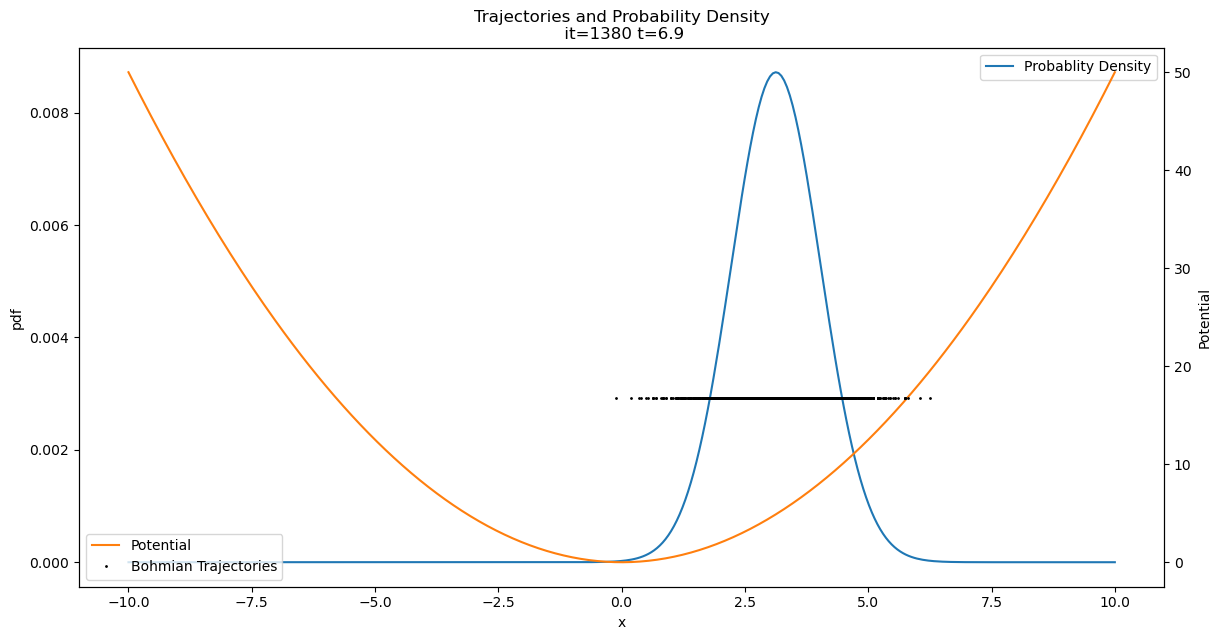

In [15]:
os.makedirs(f"./OUTPUTS/TISE_1D/{exp_name}/figs/", exist_ok=True)
image_paths = []
dpi = 100
fig = plt.figure( figsize=(14,7))

for it, t in enumerate(ts):
    if it%outputEvery==0:
        print(f"\n > It {it}/{numIts}")
        
        fig.clf()
        pdf = np.load(f"./OUTPUTS/TISE_1D/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        trajs = np.load(f"./OUTPUTS/TISE_1D/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
    
        # PDF + POTENTIAL + TRAJECTORIES ##############################################
        ax = fig.add_subplot(111)
        ax.plot(xs, pdf, label="Probablity Density")
        ax.set_xlabel("x")
        ax.set_ylabel("pdf")
        ax.set_title(f"Trajectories and Probability Density\n it={it} t={t:.4}")
        plt.legend()
        ax2=ax.twinx()
        ax2.plot(xs, V_i, label="Potential", color=u'#ff7f0e')        
        ax2.plot(trajs[:,0], [np.mean(V_i)]*numTrajs, 'o',color='black',
                markersize=1,label="Bohmian Trajectories")
        ax2.set_ylabel("Potential")
        image=f"./OUTPUTS/TISE_1D/{exp_name}/figs/it_{it}.png"
        plt.legend()
        plt.savefig(image, dpi=dpi)
        image_paths.append(image)      

Generate gif

In [16]:
import imageio
fps=5
images_for_animation = [ imageio.v2.imread(image_path) for image_path in image_paths]
imageio.mimsave(f'./OUTPUTS/TISE_1D/{exp_name}/CN_TISE_{exp_name}.gif', images_for_animation, duration=fps**-1*len(images_for_animation))

Erase png

In [17]:
#for image_path in image_paths:
#    os.remove(image_path)